# Week 6 – Arctic Regions Geospatial Wrangling

### Step 1: Wrangling and Mapping Arctic Community Data
This dataset includes Arctic territories and their number of communities.
Attributes:
- `admin`: territory name  
- `countries`: two-letter country code  
- `n_communities`: number of Arctic communities 

In [4]:
# Import libraries for geospatial data handling and plotting
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import countries polygons
fp = os.path.join('data', 'ne_50m_admin_0_countries', 'ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)

# Simplify column names
countries.columns = countries.columns.str.lower()

# Select columns for analysis
countries = countries[['admin', 'type', 'geometry']]

countries.head()

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,Sovereign country,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,Sovereign country,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [5]:
# Read in data
df = gpd.read_file("data/arctic_communities.geojson")
df.head()

,admin,country,n_communities,geometry
0,United States of America,US,115,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576..."
1,United Kingdom,GB,96,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51..."
2,Sweden,SE,133,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57..."
3,Russia,RU,774,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ..."
4,Norway,NO,48,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69..."


### Step 2: Brainstorm

**Goal:**  
Refine the Arctic communities choropleth map to include only Arctic-relevant regions (north of ~40° latitude).

**High-level steps:**  
1. Load `arctic_communities.geojson` and inspect attributes and geometry types.  
2. Standardize geometry by exploding MultiPolygons.  
3. Compute each polygon’s minimum y-coordinate (southernmost latitude).  
4. Filter polygons with min y ≥ 40° to isolate Arctic regions.  
5. Reproject data to EPSG:3413 (Arctic projection).  
6. Plot a refined choropleth using `n_communities`.  
7. Add markdown notes and commit progress regularly.

**Discussion:**  
- Why choose 40° vs 55° as the Arctic cutoff?  
- What issues might arise from mixed geometries or projections?  
- How could we define Arctic boundaries more precisely?


### Step 3: Check Geometry Types 

In [6]:
# Define a function to inspect geometry types of features in the GeoDataFrame
def check_polygons(gdf):
    geom_types = gdf.geom_type.unique()
    if len(geom_types) > 1:
        print("Multiple feature types:", geom_types)
    else:
        print("All features are:", geom_types[0])

check_polygons(df)

Multiple feature types: ['MultiPolygon' 'Polygon']


### Step 4: Explode Polygons

In [9]:
# Make multi-polygons into little polygons, then reset index 
df = df.explode(index_part = False).reset_index(drop = True)

# Ensure we only have polygons now
check_polygons(df)

All features are: Polygon


/opt/python/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  
/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/geoseries.py:924: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if s.type.startswith("Multi") or s.type == "GeometryCollection":


In [25]:
# Select first row
row = df.iloc[0]

# GeoSeries
print(type(row))  

# Shapely Polygon
print(type(row.geometry))  

# Print min_x, min_y, max_x, max_y of a shapely Polygon (row.geometry)
print(row.geometry.bounds)

# Or
df.loc[0, "geometry"].bounds[1]

<class 'pandas.core.series.Series'>
<class 'shapely.geometry.polygon.Polygon'>
(-132.948046875, 56.511035156249996, -132.56796875, 56.794775390625)


56.511035156249996

In [14]:
# Create a function to return the min y coord from a single row
def min_y(row):
    return row.geometry.bounds[1]

# Use function to apply to data frame to create new column miny with min y coordinates
df["miny"] = df.apply(min_y, axis = 1)

In [15]:
# Select polygons with a bounding box at or above 40 lat
arctic = df[df["miny"] >= 40]

# Update communities map to CRS EPSG:3413
arctic = arctic.to_crs(epsg = 3413)

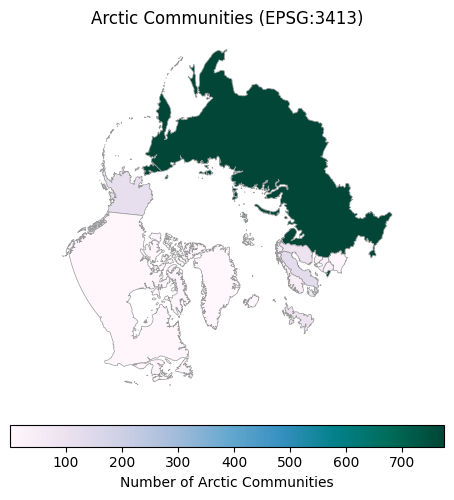

In [24]:
# Plot filtered polygons
fig, ax = plt.subplots(figsize = (8,6))

ax.axis('off')

arctic.plot(ax=ax,
            column = "n_communities",
            cmap = 'PuBuGn',
            legend = True,
            edgecolor = '0.6',
            linewidth = 0.5,
            legend_kwds={
                "shrink": 0.7,
                "label": "Number of Arctic Communities",
                "orientation":"horizontal",
                "pad": 0.05
            })

plt.title("Arctic Communities (EPSG:3413)")
plt.show()